# imports

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

from sklearn.model_selection import train_test_split
from skimage import feature,color,io,exposure
from sklearn.model_selection import cross_val_score, KFold
from tensorflow.keras.models import clone_model
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score





%matplotlib inline

# Load data

In [2]:
letter_images=pd.read_csv("D:\AI dataset\emnist-letters-train.csv")

In [3]:
letter_images.iloc[:,0]=letter_images.iloc[:,0]-1
letter_images.iloc[:,0].min(),letter_images.iloc[:,0].max()

(0, 25)

In [4]:
X=letter_images.iloc[:,1:].values
y=letter_images.iloc[:,0].values

In [5]:
X.shape,y.shape

((88799, 784), (88799,))

# split data

In [6]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=42,stratify=y,shuffle=True)

In [7]:
X_train.shape,y_train.shape

((71039, 784), (71039,))

# extract features

In [8]:
train_feature=[]
test_feature=[]

for train_img in X_train:
    train_img=train_img.reshape((28,28))
    
    hog_train_img,_=feature.hog(train_img,visualize=True)
    train_feature.append(hog_train_img)
    
for test_img in X_test:
    test_img=test_img.reshape((28,28))
    
    hog_test_img,_=feature.hog(test_img,visualize=True)
    test_feature.append(hog_test_img)
    

# example

(81,) (28, 28)


Text(0.5, 1.0, 'hog image')

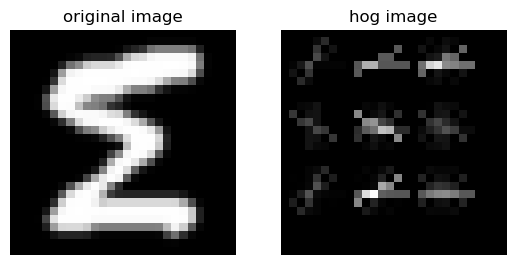

In [9]:
gray_image=X_train[0].reshape((28,28))

hog_feature,hog_img= feature.hog(gray_image,visualize=True)

plt.subplot(1,2,1)
plt.axis("off")
plt.imshow(gray_image,cmap="gray")
plt.title("original image")

plt.subplot(1,2,2)
plt.axis("off")
plt.imshow(hog_img,cmap="gray")
plt.title("hog image")

In [12]:
X_train_img=np.array(train_feature)
X_test_img=np.array(test_feature)

In [13]:
X_train_img.shape,X_test_img.shape,y_train.shape,y_test.shape

((71039, 81), (17760, 81), (71039,), (17760,))

# Model

In [14]:
model= Sequential([
    tf.keras.Input(shape=(81,)),
    Dense(units=128,activation="relu",name="layer1"),
    Dense(units=128,activation="relu",name="layer2"),
    Dense(units=26,activation="linear",name="layer3")
],name="Mymodel"
)

# Model summary

In [15]:
model.summary()

Model: "Mymodel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 128)               10496     
                                                                 
 layer2 (Dense)              (None, 128)               16512     
                                                                 
 layer3 (Dense)              (None, 26)                3354      
                                                                 
Total params: 30362 (118.60 KB)
Trainable params: 30362 (118.60 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# shape of parameters

In [16]:
[layer1,layer2,layer3]=model.layers

In [17]:
w1,b1=layer1.get_weights()
w2,b2=layer2.get_weights()

w3,b3=layer3.get_weights()

print(f"w1 shape:{w1.shape} , b1 shape: {b1.shape}")
print(f"w2 shape:{w2.shape} , b2 shape: {b2.shape}")
print(f"w3 shape:{w3.shape} , b3 shape: {b3.shape}")

w1 shape:(81, 128) , b1 shape: (128,)
w2 shape:(128, 128) , b2 shape: (128,)
w3 shape:(128, 26) , b3 shape: (26,)


# compiling (loss function)

In [18]:
model.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer=Adam(learning_rate=0.001),
    metrics=["accuracy"]
)

Epoch 1/100


2220/2220 [==============================] - 5s 2ms/step - loss: 0.9262 - accuracy: 0.7191
Epoch 2/100
2220/2220 [==============================] - 4s 2ms/step - loss: 0.5565 - accuracy: 0.8225
Epoch 3/100
2220/2220 [==============================] - 5s 2ms/step - loss: 0.4619 - accuracy: 0.8495
Epoch 4/100
2220/2220 [==============================] - 5s 2ms/step - loss: 0.4106 - accuracy: 0.8662
Epoch 5/100
2220/2220 [==============================] - 4s 2ms/step - loss: 0.3746 - accuracy: 0.8754
Epoch 6/100
2220/2220 [==============================] - 4s 2ms/step - loss: 0.3487 - accuracy: 0.8845
Epoch 7/100
2220/2220 [==============================] - 4s 2ms/step - loss: 0.3296 - accuracy: 0.8898
Epoch 8/100
2220/2220 [==============================] - 6s 2ms/step - loss: 0.3137 - accuracy: 0.8944
Epoch 9/100
2220/2220 [==============================] - 6s 3ms/step - loss: 0.2994 - accuracy: 0.8984
Epoch 10/100
2220/2220 [==============================] - 5s 2ms/step -

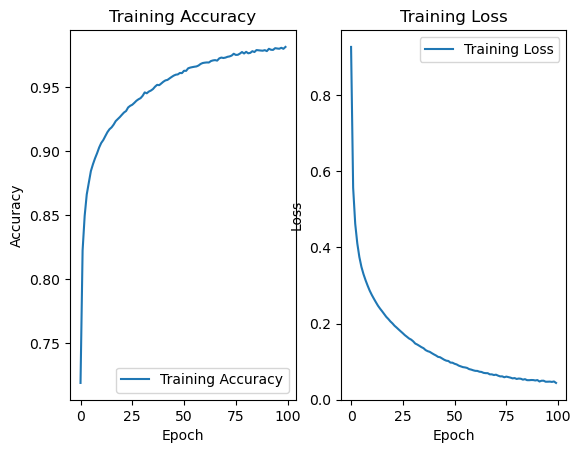

In [19]:
Letter_recognition=model.fit(
    X_train_img,y_train,
    epochs=100
)
# Plot Training Accuracy
# Plot Training Accuracy
plt.subplot(1, 2, 1)
plt.plot(Letter_recognition.history['accuracy'], label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot Training Loss
plt.subplot(1, 2, 2)
plt.plot(Letter_recognition.history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# cross validation

In [41]:

# Assuming you have X_train_img and y_train defined
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store accuracy scores for each fold
accuracy_scores = []

for train_index, test_index in kf.split(X_train_img):
    X_train_fold, X_test_fold = X_train_img[train_index], X_train_img[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

    # Train the model on the current fold
    model.fit(X_train_fold, y_train_fold, epochs=100, batch_size=32, verbose=0)

    # Evaluate the model on the test fold
    _, accuracy = model.evaluate(X_test_fold, y_test_fold, verbose=0)
    accuracy_scores.append(accuracy)

# Print the cross-validation results
print("Cross-Validation Results:")
print(accuracy_scores)
print("Mean Accuracy: {:.2f}%".format(np.mean(accuracy_scores) * 100))
print("Standard Deviation: {:.2f}%".format(np.std(accuracy_scores) * 100))


Cross-Validation Results:
[0.9208896160125732, 0.9398930072784424, 0.9506615996360779, 0.9619932174682617, 0.9694516658782959]
Mean Accuracy: 94.86%
Standard Deviation: 1.71%


# make prediction

In [20]:
prediction_model=model.predict(X_test_img)

555/555 [==============================] - 1s 936us/step


In [21]:
prediction_model[:10]

array([[ -26.453875  ,  -42.774693  ,  -35.073643  ,  -69.51373   ,
         -16.85082   ,    2.3411033 ,  -23.394865  ,  -52.182297  ,
         -22.973507  ,   -9.226403  ,   -9.946944  ,  -22.502642  ,
         -80.92451   ,  -67.7619    ,  -33.614998  ,  -21.65328   ,
         -34.548553  ,  -30.459278  ,  -56.723614  ,    8.539328  ,
         -75.144714  ,  -48.15555   ,  -73.261154  ,  -42.003773  ,
          -7.2065277 ,  -40.280033  ],
       [ -24.582687  ,  -38.239048  ,  -65.67417   ,  -87.03687   ,
         -14.458755  ,   52.25182   ,  -21.652214  ,  -66.08211   ,
         -13.753193  ,  -29.250486  ,  -41.16591   ,  -50.261684  ,
        -149.79214   , -103.66017   ,  -79.734764  ,  -16.529228  ,
         -20.828342  ,  -29.122416  ,  -21.43501   ,  -27.281122  ,
        -147.60497   ,  -82.41274   ,  -59.953358  ,  -67.574524  ,
         -72.45771   ,  -41.85605   ],
       [ -20.253307  ,  -43.552383  ,  -63.467     ,  -49.797146  ,
         -80.65965   ,  -91.00916   , 

In [22]:
prediction_p=tf.nn.softmax(prediction_model)
predicted_labels = tf.argmax(prediction_p, axis=1)


# accuracy

In [23]:
loss,accurecy=model.evaluate(X_test_img,y_test)

555/555 [==============================] - 1s 1ms/step - loss: 0.9085 - accuracy: 0.8791


In [24]:
accurecy

0.8791103363037109

# all the mertics for classification

In [27]:
accuracy = accuracy_score(y_test, predicted_labels)
precision = precision_score(y_test, predicted_labels, average='weighted')  # Set average to 'weighted'
recall = recall_score(y_test, predicted_labels, average='weighted')  # Set average to 'weighted'
f1 = f1_score(y_test, predicted_labels, average='weighted')  # Set average to 'weighted'

print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))


Accuracy: 87.91%
Precision: 0.88
Recall: 0.88
F1 Score: 0.88


# saving the model


In [48]:
model.save('D:/Ai model/model1')


INFO:tensorflow:Assets written to: D:/Ai model/model1\assets


INFO:tensorflow:Assets written to: D:/Ai model/model1\assets
